# TASK 2 - ALKEMY PROJECT

In [1]:
#Importing libraries
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
# from sklearn.cluster import DBSCAN

from xgboost import XGBRegressor
from xgboost import plot_importance
import shap

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot

from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("dbcreation_alkemy").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 23:27:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Sales approach

In [4]:
df = spark.read.csv('sales_data_all.csv', header=True, inferSchema=True)
df = df.withColumn("sale_date", F.to_date("sale_date").cast('date'))
df = df.withColumn("quarter",   F.quarter(df.sale_date))
df = df.withColumn('profit',    (df.regular_price - df.purchase_price) * df.quantity)

In [5]:
def myfunc(q):

    # Filter by quarter
    my_df = df.filter(df.quarter == q)

    # Group by product_id and sum quantities and profits
    my_df = my_df.groupBy('product_id').sum('quantity', 'profit')

    # Calculate the popularity index = quantity / sum(quantity)
    my_df = my_df.withColumn('pop_index', my_df['sum(quantity)'] / \
                                            my_df.agg(F.sum("sum(quantity)")).collect()[0][0])

    # Get the minimum and maximum for popularity index and MinMax.scale it
    min = my_df.agg(F.min("pop_index")).collect()[0][0]
    max = my_df.agg(F.max("pop_index")).collect()[0][0]

    my_df = my_df.withColumn('pop_index_perc', ((my_df.pop_index - min) / (max - min)))

    # Do the same with profits
    min = my_df.agg(F.min("sum(profit)")).collect()[0][0]
    max = my_df.agg(F.max("sum(profit)")).collect()[0][0]

    my_df = my_df.withColumn('profit_perc',  ((my_df['sum(profit)'] - min) / (max - min)))

    # Rename columns
    my_df = my_df.withColumnRenamed("sum(profit)","profit")\
                            .withColumnRenamed('sum(quantity)','quantity')

    my_df = my_df.toPandas()

    return my_df

var = myfunc(1)

In [7]:
print('10 most popular products:\n', var.sort_values('pop_index_perc', ascending=False)['product_id'].head(10))

10 most popular products:
 1482    110853
839     156095
3551    107645
2618    145377
3601    157318
2355    143220
3943    155431
1942    157315
4640    122291
2611    128194
Name: product_id, dtype: int32


In [ ]:
# Investigate the contribution to revenues for the n% most popular products
def ABC(X):
    top_ten = list(var[var['pop_index_perc'] > X].product_id.unique().tolist())
    my_df = var[var['product_id'].isin(top_ten)].reset_index(drop = True)
    perc = X*100
    print('Contribution to total revenues of the ', str(perc), '%', 'most popular products =', my_df.profit.sum()/var.profit.sum())
ABC(0.1)

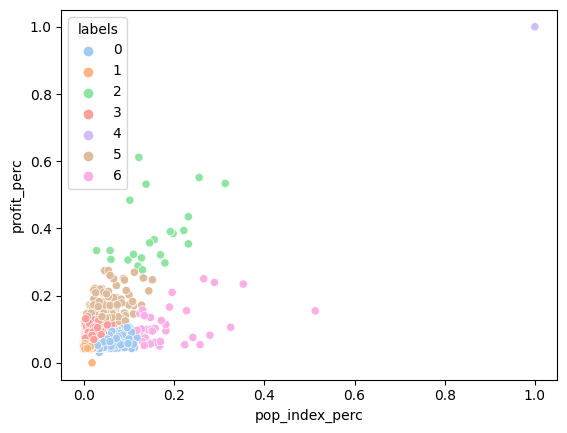

In [9]:
# Create areas for framework-related analysis using unsupervised learning
def vincolo_clustering():
    model = KMeans(n_clusters= 7,
                   init = 'k-means++')
    #model = DBSCAN(eps = 0.05, metric = 'manhattan')
    model.fit(var[['pop_index_perc', 'profit_perc']])
    var['labels'] = model.labels_
    sns.scatterplot(x = var['pop_index_perc'], y=var['profit_perc'], hue = var['labels'], palette="pastel")

vincolo_clustering()

## Clicks approach

In [11]:
# Analyse the popularity based on clicks
df = spark.read.csv('clicks_concatenato.csv',
                    header=True,
                    inferSchema=True).select('date','seller','position',
                                             'price_max','price_min','price',
                                             'type','product_id')

# Cast dates and extract quarters
df = df.withColumn("date",      F.to_date("date").cast('date'))
df = df.withColumn("quarter",   F.quarter(df.date))

df.show()

+----------+------+--------+---------+---------+-----+-------+----------+-------+
|      date|seller|position|price_max|price_min|price|   type|product_id|quarter|
+----------+------+--------+---------+---------+-----+-------+----------+-------+
|2020-01-01|    48|    null|   5290.0|   5290.0| null|Regular|    148875|      1|
|2020-01-01|    48|    null|  11787.0|   9990.0| null|Regular|    104538|      1|
|2020-01-01|    23|    null|  16217.0|  16217.0| null|Regular|    108283|      1|
|2020-01-01|    48|    null|   7399.0|   6398.0| null|Regular|    144718|      1|
|2020-01-01|   407|    null|   3343.0|   2299.0| null|Regular|    144776|      1|
|2020-01-01|    24|    null|  12999.0|   9491.0| null|Regular|    132634|      1|
|2020-01-01|    24|    null|  10890.0|   9290.0| null|Regular|    110429|      1|
|2020-01-01|    24|    null|  31690.0|  28999.0| null|Regular|    141943|      1|
|2020-01-01|    24|    null|  43199.0|  43199.0| null|Regular|    128665|      1|
|2020-01-01|    

In [12]:
df = df.toPandas()

# Import click dataset
def click(q):

    # Filter by quarter
    copydf = df[df.quarter == q]

    def preprocessing(dataframe):

        # Count the number of click
        total_click = len(dataframe)

        # Group by product_id and count the occurrences
        df_tot = dataframe.groupby('product_id').size().reset_index()
        df_tot.rename(columns = {0: 'click'}, inplace = True)

        # Calculate the popularity index and normalize it
        df_tot['pop_index'] = df_tot['click']/total_click
        df_tot['pop_index_norm'] = (df_tot['pop_index'] - df_tot['pop_index'].min())\
                                            / (df_tot['pop_index'].max() - df_tot['pop_index'].min())
        return df_tot

    # Popularity index of the market
    my_df_tot = preprocessing(copydf)

    # Popularity index for seller 24
    my_df_24 = copydf[copydf['seller'] == 24]
    my_df_24 = preprocessing(my_df_24)

    # Merge the datasets, showing only products sold by s. 24
    final = pd.merge(my_df_tot, my_df_24, on='product_id', how='right', suffixes = ['total','24'])
    #sns.scatterplot(data = final, x = 'pop_index_normtotal', y = 'pop_index_norm24')
    return final

df_clicks = click(1)

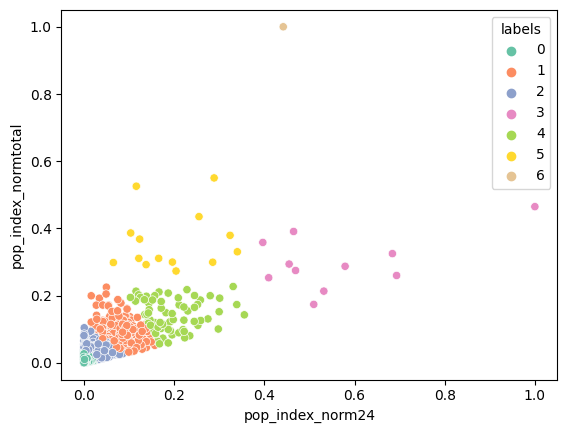

In [13]:
def clustering():
    model = KMeans(n_clusters= 7,
                   init = 'k-means++')
    #model = DBSCAN(eps = 0.05, metric = 'manhattan')
    model.fit(df_clicks[['pop_index_normtotal', 'pop_index_norm24']])
    df_clicks['labels'] = model.labels_
    sns.scatterplot(x = df_clicks['pop_index_norm24'], y=df_clicks['pop_index_normtotal'], hue = df_clicks['labels'], palette="Set2")

clustering()

In [14]:
clicks_merged = pd.merge(df, df_clicks, on='product_id', how='left')
clicks_merged['date'] = pd.to_datetime(clicks_merged['date'])
clicks_merged = clicks_merged[clicks_merged['date'].dt.year == 2021].dropna()

In [15]:
#X = clicks_merged.iloc[:, clicks_merged.columns != ["pop_index_normtotal",'product_id','pop_indextotal','click24','pop_index24','pop_index_norm24']]
X = clicks_merged.drop(['labels','clicktotal','pop_index_normtotal','date','product_id','pop_indextotal','click24','pop_index24','pop_index_norm24'], axis = 1)
X = pd.get_dummies(X, columns = ['type'])

y = clicks_merged["pop_index_normtotal"]
                       
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Train dataset shape: {train_X.shape}")
print(f"Test dataset shape: {test_X.shape}")

Train dataset shape: (828714, 8)
Test dataset shape: (207179, 8)


In [16]:
xgb_r = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

[23:28:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.056141


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

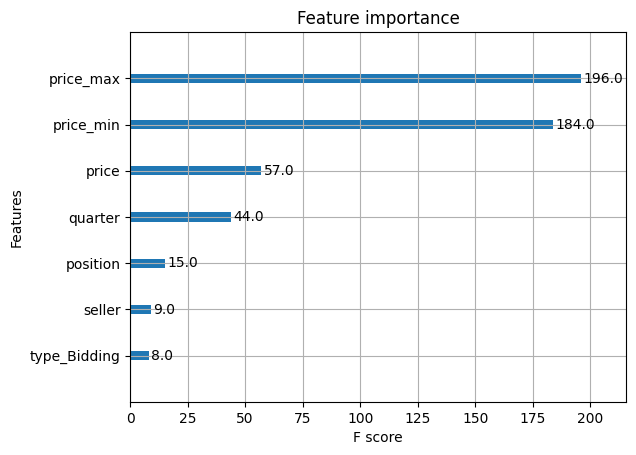

In [20]:
plot_importance(xgb_r)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


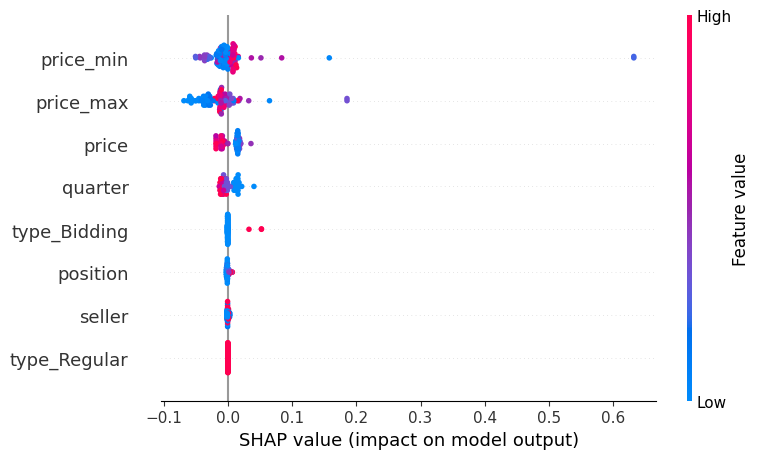

In [21]:
X_sampled = train_X.sample(100, random_state=10)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(X_sampled)

# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)